#**DualLayer 클래스 구현하기**

SingleLayer 클래스를 상속하여 필요한 메서드만 재정의 하여 DualLayer 클래스를 만들어보자.

In [ ]:
# import dependencies

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# divid samples into train, val, test sets

cancer = load_breast_cancer()
c_data = cancer.data
c_target = cancer.target
train_data_all, test_data, train_target_all, test_target = train_test_split(c_data, c_target, stratify=c_target, test_size=0.2, random_state=42)
train_data, val_data, train_target, val_target = train_test_split(train_data_all, train_target_all, stratify=train_target_all, test_size=0.2, random_state=42)
print(train_data.shape, val_data.shape)

(364, 30) (91, 30)


In [ ]:
class SingleLayer:

  def __init__(self, learning_rate=0.1, l1=0, l2=0):
    self.w = None   # 입력데이터의 특성이 많아 가중치와 절편을 미리 초기화하지 않는다.
    self.b = None   # 나중에 입력데이터를 보고 특성 개수에 맞게 결정
    self.losses = []
    self.w_history = []   # 가중치를 저장할 리스트
    self.lr = learning_rate   # 학습률 
    self.val_losses = []    # 검증세트 손실을 기록할 리스트
    self.l1 = l1
    self.l2 = l2

  def forpass(self, x):
    z = np.dot(x, self.w) + self.b   # x=(364, 30) dot w=(30, 1) = z=(364, 1)
    return z


  def backprop(self, x, err):   # 오차역전파 메서드
    m = len(x)
    w_grad = np.dot(x.T, err) / m # x.T=(364, 30) dot err=(30, 1) = w_grad=(364, 1)
    b_grad = np.sum(err) / m  # err/m = (364, 1)
    return w_grad, b_grad


  def fit(self, x, y, epochs=100, x_val=None, y_val=None):  # 검증세트를 전달받을 x_val, y_val 추가
    y = y.reshape(-1, 1)  # 타깃을 열벡터로 바꾼다.
    y_val = y_val.reshape(-1, 1)  # 검증타깃을 열벡터로 바꾼다.
    m = len(x)
    self.w = np.ones((x.shape[1], 1))  # 가중치와 절편 초기화
    self.b = 0
    self.w_history.append(self.w.copy())  # 가중치 기록 -> 넘파이 배열(w)을 추가하면 실제값이 추가되는 것이 아닌 배열을 참조하기 때문에 w값이 바뀌면 그 값을 복사하여 추가해주어야 한다.
    np.random.seed(42)
    for i in range(epochs):
      z = self.forpass(x)   # 정방향 계산
      a = self.activation(z)  # 정방향 계산의 결과값인 z를 활성화 함수에 통과
      err =  -(y - a)       # 활성화 함수를 거친 a값으로 오차량 계산
      w_grad, b_grad = self.backprop(x, err)  # 오차역전파
      w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m # 그레이디언트에서 패널티 항의 미분값을 더한다.
      self.w -= self.lr * w_grad   # 그레이디언트 업데이트  (학습률 적용)
      self.b -= self.lr * b_grad
      self.w_history.append(self.w.copy())  # 가중치 기록
      a = np.clip(a, 1e-10, 1-1e-10)
      loss = np.sum(-(y * np.log(a) + (1 - y) * np.log(1 - a)))  # 로지스틱 손실함수 -(ylog(a) - (1 - y)log(1 - a))
      self.losses.append((loss + self.reg_loss()) / m)
      self.update_val_loss(x_val, y_val)  # 검증세트 손실을 업데이트하는 메서드 호출


  def reg_loss(self):
    return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)

  
  def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)
    a = self.activation(z)
    a = np.clip(a, 1e-10, 1-1e-10)
    val_loss = np.sum(-(y_val * np.log(a) + (1 - y_val) * np.log(1 - a)))
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))


  def activation(self, z):  # 활성화 함수
    z = np.clip(z, -100, None)    # 안전한 계산을 위해 클리핑
    a = 1 / (1 + np.exp(-z))
    return a


  def predict(self, x): # 예측 함수
    z = self.forpass(x)
    return z > 0  # 계단함수


  def score(self, x, y):    # 평가함수
    return np.mean(self.predict(x) == y.reshape(-1, 1))

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_data)  # train_data를 넣어 fit()하여 변환 규칙을 익히고
train_data_scaled = scaler.transform(train_data)  # 표준화 전처리
val_data_scaled = scaler.transform(val_data)

#**DualLayer Class**

In [ ]:
class DualLayer(SingleLayer):

  def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
    self.units = units  # 은닉층 유닛 개수
    self.w1 = None      # 은닉층의 가중치
    self.b1 = None      # 은닉층의 절편
    self.w2 = None      # 출력층의 가중치
    self.b2 = None      # 출력층의 절편
    self.a1 = None      # 은닉층의 활성화 출력
    self.losses = []    # 훈련 손실
    self.val_losses = []  # 검증 손실
    self.lr = learning_rate # 학습률
    self.l1 = l1    # L1 손실 파라미터
    self.l2 = l2    # L2 손실 파라미터

  
  def forpass(self, x):
    z1 = np.dot(x, self.w1) + self.b1
    self.a1 = self.activation(z1)
    z2 = np.dot(self.a1, self.w2) + self.b2
    return z2

  
  def backprop(self, x, err):
    m = len(x)
    w2_grad = np.dot(self.a1.T, err) / m  # 출력층 그레이디언트
    b2_grad = np.sum(err) / m
    err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)  # 시그모이드 함수까지 그레이디언트 계산
    w1_grad = np.dot(x.T, err_to_hidden) / m
    b1_grad = np.sum(err_to_hidden, axis=0) / m
    return w1_grad, b1_grad, w2_grad, b2_grad


  def init_weights(self, n_features):
    self.w1 = np.ones((n_features, self.units))   # 가중치 행렬 초기화 (특성개수, 뉴런 개수(은닉층 크기))
    self.b1 = np.zeros(self.units)  # 뉴런 개수(은닉층 크기)
    self.w2 = np.ones((self.units, 1))  # (뉴런 개수(은닉층 크기), 1)
    self.b2 = 0

  
  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    y = y.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)
    m = len(x)
    self.init_weights(x.shape[1])
    for i in range(epochs):
      a = self.training(x, y, m)
      a = np.clip(a, 1e-10, 1-1e-10)
      loss = np.sum(-(y * np.log(a) + (1 - y) * np.log(1 - a)))
      self.losses.append((loss + self.reg_loss()) / m)
      self.update_val_loss(x_val, y_val)

  
  def training(self, x, y, m):
    z = self.forpass(x)
    a = self.activation(z)
    err = -(y - a)
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad
    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad
    return a


  def reg_loss(self):
    return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
            self.l2 / 2 *(np.sum(self.w1**2) + np.sum(self.w2**2))

#**모델 훈련하기**

L2 규제는 0.01만큼, 에포크는 20000번으로 지정하고 훈련을 진행해보자.

In [ ]:
dual_layer = DualLayer(l2=0.01)
dual_layer.fit(train_data_scaled, train_target, x_val=val_data_scaled, y_val=val_target, epochs=20000)
dual_layer.score(val_data_scaled, val_target)

0.978021978021978

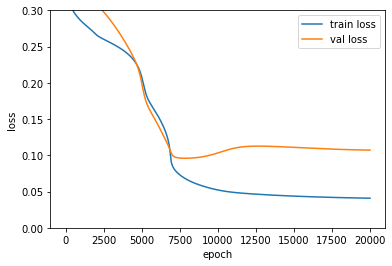

In [ ]:
plt.ylim(0, 0.3)
plt.plot(dual_layer.losses)
plt.plot(dual_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'])
plt.show()

손실 그래프가 이전보다 천천히 감소한다.   
SingleLayer보다 가중치의 개수가 훨씬 많아져 학습하는데 시간이 오래걸리기 때문이다.   


#**가중치 초기화 개선하기**

손실 그래프를 보면 초기 손실값이 감소하는 곡선이 매끄럽지 않다.   
이는 우리가 단순히 가중치를 1로 초기화하여 손실함수가 감소하는 방향을 올바르게 찾는 데   
시간이 많이 소요된 것 같다.   

이번에는 np.random.normal() 함수를 사용하여 정규분포를 따르는 무작위 수로 가중치를 초기화해보자.

DualLayer 클래스를 상속하는 RandomInitNetwork 클래스를 만들어 init_weights() 메서드만 수정할 것이다.

In [ ]:
class RandomInitNetwork(DualLayer):

  def init_weights(self, n_features):
    np.random.seed(42)
    self.w1 = np.random.normal(0, 1, (n_features, self.units))  # np.random.normal(평균, 표준편차, 배열크기)
    self.b1 = np.zeros(self.units)
    self.w2 = np.random.normal(0, 1, (self.units, 1))
    self.b2 = 0

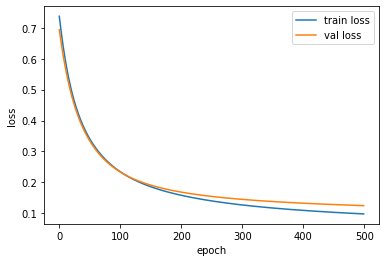

In [ ]:
random_init_net = RandomInitNetwork(l2=0.01)
random_init_net.fit(train_data_scaled, train_target, x_val=val_data_scaled, y_val=val_target, epochs=500)

plt.plot(random_init_net.losses)
plt.plot(random_init_net.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'])
plt.show()